Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization


In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('/content/drive/MyDrive/CNN/Train')
data_dir_test = pathlib.Path('/content/drive/MyDrive/CNN/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(img_height,img_width),
    batch_size=batch_size,
    validation_split=0.2,
    seed = 123,
    subset='training'
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(img_height,img_width),
    batch_size=batch_size,
    validation_split=0.2,
    seed=123,
    subset='validation'
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

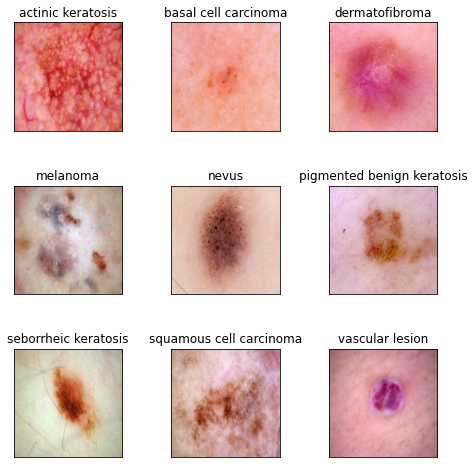

In [10]:
import matplotlib.pyplot as plt

class_names = val_ds.class_names
fig = plt.figure(figsize=(8,8))
for i, class_name in enumerate(class_names):
    ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
    for images, labels in train_ds:
        
        indices = tf.where(labels == i)

        if len(indices) == 0:
          
          continue
        image = images[indices[0, 0]]
        image = tf.keras.preprocessing.image.img_to_array(image)
        image = tf.keras.preprocessing.image.array_to_img(
            tf.keras.preprocessing.image.img_to_array(image) / 255.0
        )
        ax.set_title(class_name)
        plt.imshow(image)
        
        break
plt.subplots_adjust(hspace=0.5)
plt.show()

### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
num_classes = len(class_names)

In [13]:
input_shape = train_ds.element_spec[0].shape[1:]

In [14]:
print(input_shape)

(180, 180, 3)


In [15]:
# train_labels = np.array([label.numpy() for _, label in train_ds])
# val_labels = np.array([label.numpy() for _, label in val_ds])

In [16]:
train_labels = np.array([label.numpy()[0] for _, label in train_ds])
val_labels = np.array([label.numpy()[0] for _, label in val_ds])

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes)

In [17]:
input_shape = train_ds.element_spec[0].shape[1:]

In [18]:
print(num_classes)
print(input_shape)

9
(180, 180, 3)


### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [19]:
### Your code goes here
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255))
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(num_classes, activation='softmax'))

In [20]:
model.build(input_shape=(None,) + input_shape)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [21]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                        

### Train the model

In [23]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 15s 86ms/step - loss: 2.0386 - accuracy: 0.2009 - val_loss: 2.0025 - val_accuracy: 0.2103
Epoch 2/20
56/56 [==============================] - 4s 74ms/step - loss: 1.9943 - accuracy: 0.2561 - val_loss: 2.0144 - val_accuracy: 0.2192
Epoch 3/20
56/56 [==============================] - 4s 75ms/step - loss: 1.9645 - accuracy: 0.2757 - val_loss: 1.9903 - val_accuracy: 0.2416
Epoch 4/20
56/56 [==============================] - 4s 74ms/step - loss: 1.9325 - accuracy: 0.2846 - val_loss: 1.9147 - val_accuracy: 0.3043
Epoch 5/20
56/56 [==============================] - 4s 75ms/step - loss: 1.8874 - accuracy: 0.2935 - val_loss: 2.0462 - val_accuracy: 0.2125
Epoch 6/20
56/56 [==============================] - 4s 77ms/step - loss: 1.8745 - accuracy: 0.2958 - val_loss: 1.7555 - val_accuracy: 0.3781
Epoch 7/20
56/56 [==============================] - 4s 75ms/step - loss: 1.8435 - accuracy: 0.3281 - val_loss: 1.8805 - val_accuracy: 0.2864
Epoch 8/20
5

### Visualizing training results

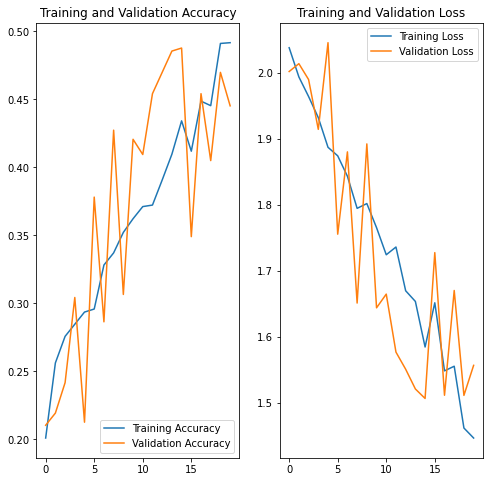

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

As we can see on the left graph, validation accuracy is sometimes surpassing the test accuracy score, which is rather strange but given both test and validation accuracy are around 0.5, this is clear case of underfitting. Also the cross entropy loss for validation is higher than training, which again suggests underfitting, accuracy score shows conclusive proof that this is a case of underfitting

### Write your findings here

In [25]:
def augment_image(image, label):
    image = datagen.random_transform(image)
    return image, label

In [26]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
datagen = ImageDataGenerator(
  rotation_range=20,
  zoom_range=0.2,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest'
)

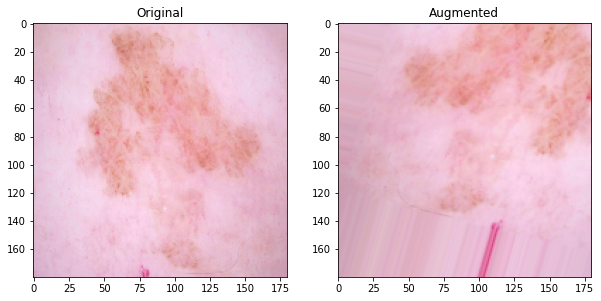

In [27]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
batch = next(iter(train_ds))
image = batch[0][1]
image = image.numpy() 
# print(image.shape)
transform_params = datagen.get_random_transform(image.shape)
augmented_image = datagen.apply_transform(image, transform_params)
# normalize image array
image = image / np.max(image)
augmented_image = augmented_image / np.max(augmented_image)
# print(image.shape)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title("Original")
axes[1].imshow(augmented_image)
axes[1].set_title("Augmented")
plt.show()

In [28]:
# augment all the images of the train dataset
for images, labels in train_ds:
    updated_images = []
    for i in range(images.shape[0]):
        image_numpy = images[i].numpy()
        transform_params = datagen.get_random_transform(image_numpy.shape)
        image_numpy = datagen.apply_transform(
            image_numpy, transform_params)
        updated_images.append(tf.convert_to_tensor(image_numpy))
    updated_images = tf.stack(updated_images)
    images = tf.concat([updated_images, images[images.shape[0]:]], axis=0)

### Todo:
### Create the model, compile and train the model


In [29]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
### Your code goes here
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255))
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.30))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.30))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))


### Compiling the model

In [30]:
## Your code goes here
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [31]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 111ms/step - loss: 2.0530 - accuracy: 0.1942 - val_loss: 2.0861 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 6s 106ms/step - loss: 2.0125 - accuracy: 0.2344 - val_loss: 2.0312 - val_accuracy: 0.3423
Epoch 3/20
56/56 [==============================] - 6s 108ms/step - loss: 1.9847 - accuracy: 0.2612 - val_loss: 1.9622 - val_accuracy: 0.3311
Epoch 4/20
56/56 [==============================] - 6s 109ms/step - loss: 1.9314 - accuracy: 0.2818 - val_loss: 1.8927 - val_accuracy: 0.3826
Epoch 5/20
56/56 [==============================] - 6s 110ms/step - loss: 1.8751 - accuracy: 0.3013 - val_loss: 1.9131 - val_accuracy: 0.2819
Epoch 6/20
56/56 [==============================] - 6s 110ms/step - loss: 1.8325 - accuracy: 0.3181 - val_loss: 1.9521 - val_accuracy: 0.3087
Epoch 7/20
56/56 [==============================] - 6s 109ms/step - loss: 1.8032 - accuracy: 0.3382 - val_loss: 2.1732 - val_accuracy: 0.2036
Epoch 

### Visualizing the results

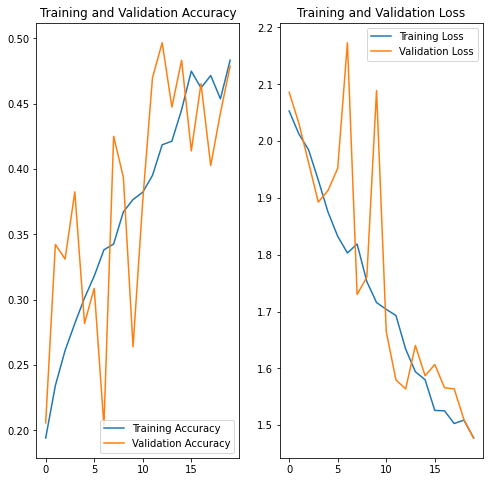

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

I can still see training and validation, the accuracies of both are less than 50, which suggests the undersitting is still there. Basically data augmentation didn't help much. The loss and accuracy are both in line with what we have got earlier, without dropouts and data augmentation

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [33]:
#class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [34]:
class_indices = {}
for i, class_name in enumerate(class_names):
    class_indices[class_name] = i
counts = np.zeros(9)
for images, labels in train_ds:
    #print(labels.shape)
    for label in labels:
        #for label in label_batch:
       # print(int(label))
        counts[int(label)] += 1

# Calculate the proportion of images in each class
proportions = counts / sum(counts)

# Print the class distribution
for class_name in class_names:
    class_index = class_indices[class_name]
    print(f"{class_name}: {proportions[class_index]:.2%}")
    #print(f"Class {i}: {counts[i]:.2}")

actinic keratosis: 5.13%
basal cell carcinoma: 17.24%
dermatofibroma: 4.30%
melanoma: 19.64%
nevus: 15.46%
pigmented benign keratosis: 20.65%
seborrheic keratosis: 3.24%
squamous cell carcinoma: 7.92%
vascular lesion: 6.42%


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
sebarrheic keratosis has the least number of samples

#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis dominate the data in terms proportionate number of samples

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [35]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [36]:
path_to_training_dataset= data_dir_train
import Augmentor
for i in class_names:
    class_path = os.path.join(path_to_training_dataset, i)
    output_path = os.path.join(class_path, 'output')
    if not os.path.exists(output_path):
      print(f'Augmenting images for class {i}')
      path = str(path_to_training_dataset).rstrip(' ') + '/' + i.lstrip(' ')
      print(path)
      # p = Augmentor.Pipeline(path_to_training_dataset + i) // not needed
      p = Augmentor.Pipeline(path)
      p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
      p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.
    else:
      print(f'Output folder already exists for class {i}. Skipping augmentation.')

Augmenting images for class actinic keratosis
/content/drive/MyDrive/CNN/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F33A0317F10>: 100%|██████████| 500/500 [00:25<00:00, 19.95 Samples/s]


Augmenting images for class basal cell carcinoma
/content/drive/MyDrive/CNN/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F33A02D8FA0>: 100%|██████████| 500/500 [00:27<00:00, 18.27 Samples/s]


Augmenting images for class dermatofibroma
/content/drive/MyDrive/CNN/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F33A033F580>: 100%|██████████| 500/500 [00:20<00:00, 24.51 Samples/s]


Augmenting images for class melanoma
/content/drive/MyDrive/CNN/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F3420118670>: 100%|██████████| 500/500 [01:43<00:00,  4.81 Samples/s]


Augmenting images for class nevus
/content/drive/MyDrive/CNN/Train/nevus
Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F33AA198910>: 100%|██████████| 500/500 [01:33<00:00,  5.37 Samples/s]


Augmenting images for class pigmented benign keratosis
/content/drive/MyDrive/CNN/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F342013AE50>: 100%|██████████| 500/500 [00:21<00:00, 22.80 Samples/s]


Augmenting images for class seborrheic keratosis
/content/drive/MyDrive/CNN/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F343A728C70>: 100%|██████████| 500/500 [00:48<00:00, 10.39 Samples/s]


Augmenting images for class squamous cell carcinoma
/content/drive/MyDrive/CNN/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F33AA109910>: 100%|██████████| 500/500 [00:21<00:00, 23.05 Samples/s]


Augmenting images for class vascular lesion
/content/drive/MyDrive/CNN/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F33A0498280>: 100%|██████████| 500/500 [00:20<00:00, 24.47 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [37]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [38]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
unique_items = set(lesion_list_new)
print(list(unique_items))

['dermatofibroma', 'vascular lesion', 'basal cell carcinoma', 'nevus', 'melanoma', 'actinic keratosis', 'squamous cell carcinoma', 'pigmented benign keratosis', 'seborrheic keratosis']


In [40]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))


In [41]:
jpeg_files = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg')) if 'output' not in x]

# Extract lesion labels from directory names
lesion_list_old = [os.path.basename(os.path.dirname(y)) for y in jpeg_files]

# Create dataframe
original_df = pd.DataFrame({'Path': jpeg_files, 'Label': lesion_list_old})
print(original_df.head())

                                                Path  Label
0  /content/drive/MyDrive/CNN/Train/nevus/ISIC_00...  nevus
1  /content/drive/MyDrive/CNN/Train/nevus/ISIC_00...  nevus
2  /content/drive/MyDrive/CNN/Train/nevus/ISIC_00...  nevus
3  /content/drive/MyDrive/CNN/Train/nevus/ISIC_00...  nevus
4  /content/drive/MyDrive/CNN/Train/nevus/ISIC_00...  nevus


In [42]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)
new_df.head()

<ipython-input-42-30768ff93bcf>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


,Path,Label
0,/content/drive/MyDrive/CNN/Train/nevus/ISIC_00...,nevus
1,/content/drive/MyDrive/CNN/Train/nevus/ISIC_00...,nevus
2,/content/drive/MyDrive/CNN/Train/nevus/ISIC_00...,nevus
3,/content/drive/MyDrive/CNN/Train/nevus/ISIC_00...,nevus
4,/content/drive/MyDrive/CNN/Train/nevus/ISIC_00...,nevus


In [43]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [44]:
batch_size = 32
img_height = 180
img_width = 180

In [45]:
data_dir_train

PosixPath('/content/drive/MyDrive/CNN/Train')

#### **Todo:** Create a training dataset

In [46]:
import shutil

new_data_dir = '/content/drive/MyDrive/CNN2/Train'


for class_name in class_names:
    print(class_name)
    # Create a directory for the current class in the new data directory
    class_dir = os.path.join(new_data_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

    # Get the path to the output directory for the current class
    output_dir = os.path.join(data_dir_train, class_name, 'output')

    # Copy all JPEG files in the output directory to the current class directory in the new data directory
    for filename in os.listdir(output_dir):
        if filename.endswith('.jpg'):
            src_path = os.path.join(output_dir, filename)
            dst_path = os.path.join(class_dir, filename)
            shutil.copyfile(src_path, dst_path)

    # Copy all JPEG files in the current class directory (excluding the output directory) to the current class directory in the new data directory
    class_dir_orig = os.path.join(data_dir_train, class_name)
    for filename in os.listdir(class_dir_orig):
        if filename.endswith('.jpg') and filename not in os.listdir(class_dir):
            src_path = os.path.join(class_dir_orig, filename)
            dst_path = os.path.join(class_dir, filename)
            shutil.copyfile(src_path, dst_path)

actinic keratosis
basal cell carcinoma
dermatofibroma
melanoma
nevus
pigmented benign keratosis
seborrheic keratosis
squamous cell carcinoma
vascular lesion


In [47]:
data_dir_train=new_data_dir
train_ds_new = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [48]:
val_ds_new = tf.keras.preprocessing.image_dataset_from_directory(
  new_data_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [49]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255))
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [50]:
## your code goes here
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [51]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds_new,
  validation_data=val_ds_new,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 45s 248ms/step - loss: 1.6354 - accuracy: 0.4418 - val_loss: 2.9391 - val_accuracy: 0.1151
Epoch 2/30
169/169 [==============================] - 44s 256ms/step - loss: 1.1454 - accuracy: 0.5914 - val_loss: 2.7769 - val_accuracy: 0.1240
Epoch 3/30
169/169 [==============================] - 39s 223ms/step - loss: 0.8656 - accuracy: 0.6895 - val_loss: 2.1690 - val_accuracy: 0.2836
Epoch 4/30
169/169 [==============================] - 44s 249ms/step - loss: 0.7045 - accuracy: 0.7533 - val_loss: 1.8161 - val_accuracy: 0.3972
Epoch 5/30
169/169 [==============================] - 41s 240ms/step - loss: 0.5514 - accuracy: 0.8125 - val_loss: 1.2779 - val_accuracy: 0.5516
Epoch 6/30
169/169 [==============================] - 40s 232ms/step - loss: 0.4723 - accuracy: 0.8425 - val_loss: 1.1352 - val_accuracy: 0.5969
Epoch 7/30
169/169 [==============================] - 41s 239ms/step - loss: 0.3992 - accuracy: 0.8654 - val_loss: 0.7241 - val_ac

#### **Todo:**  Visualize the model results

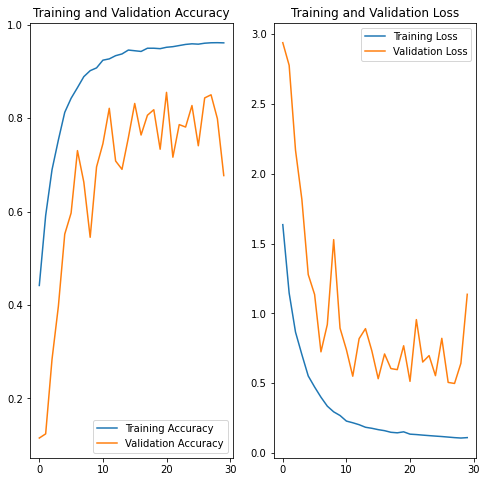

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Definitely class rebalancing helped in getting rid of underfitting. Rather, it is slightly overfitting now. At epoch = 21, the training accuracy reached 95.18% and validation accuracy reached almost 85.5%. This is a very good result as compared to the accuracies of previous two models. This is near perfect. Augmentation + class rebalancing + batch normalization all three combined created a very good model for this use case.